# DEM raster data analysis in Python using rasterio , richDEM , geopandas , and shapely

参考：https://www.youtube.com/watch?v=6wqFzbiU8uY


Slopeは0-90度の角度で傾斜を表し、aspectは0-360度の範囲で方向を示す。

例えば、Slope:75, aspect:180 の場合は、真南に75度の急な傾斜がある、ということを表している。

In [30]:
!pip install richdem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 KB 7.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [185 lines of output]
      Using RichDEM hash=Unknown, time=Unknown
      /usr/local/lib/python3.10/dist-packages/setuptools/dist.py:723: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-aarch64-3.10
      creating build/lib.linux-aarch64-3.10/richdem
      copying richdem/cli.py -> build/lib.linux-aarch64-3.10/richdem
      copying richdem/__init__.py -> build/lib.linux-aarch64-3.10/richdem
      running build_ext
      COMPILER unix
      COMPILER ARGUMENTS ['-std=c++11', '-g', '-fvisibil

In [31]:
import rasterio
from rasterio import plot

import richdem as rd

import geopandas as gpd

from shapely.geometry import Point

ModuleNotFoundError: No module named 'richdem'

# 参考X：Digital Elevation Model (DEM) in Python

https://medium.com/spatial-data-science/digital-elevation-model-dem-in-python-758f0ede3af8



In [1]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt

# 以下は、DEM関係なく、ラスターデータの扱い方についての内容になっている

参考：https://github.com/geohackweek/raster-2019

## ラスターデータとベクターデータ

- ベクターデータ：地表の特定の機能を表し、属性を割り当てたデータ（点や線、ポリゴンで表現される）
- ラスターデータ：ピクセルとして表現される値をグリッド状に格納したデータ


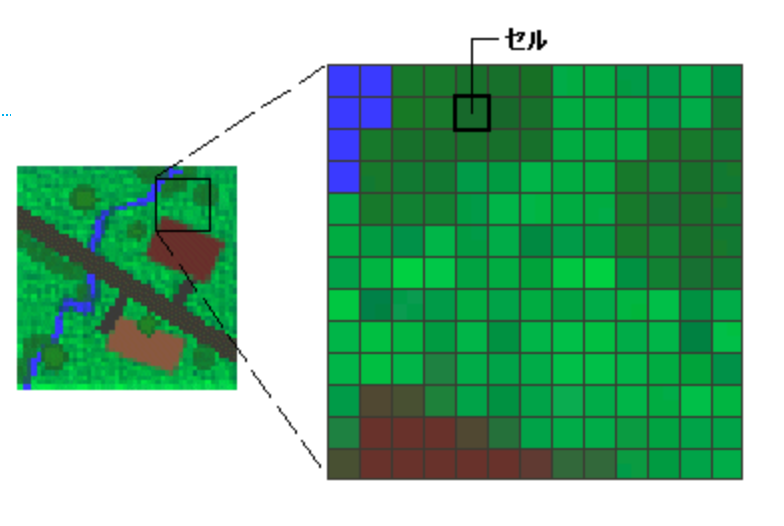

参考：[ラスターデータ - esriジャパン](https://www.esrij.com/gis-guide/gis-datamodel/raster-data/#:~:text=%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%BC%20%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AF%E3%80%81%E8%A1%8C%E3%81%A8,%E3%81%8C%E3%82%8F%E3%81%8B%E3%82%8B%E3%81%A8%E6%80%9D%E3%81%84%E3%81%BE%E3%81%99%E3%80%82)

## ラスターデータの例

- ALOSやSentinelなどの衛星画像
- DEM（数値標高モデル）のデータ
- LiDARデータ
- 土地被覆マップ

など

LiDARとは

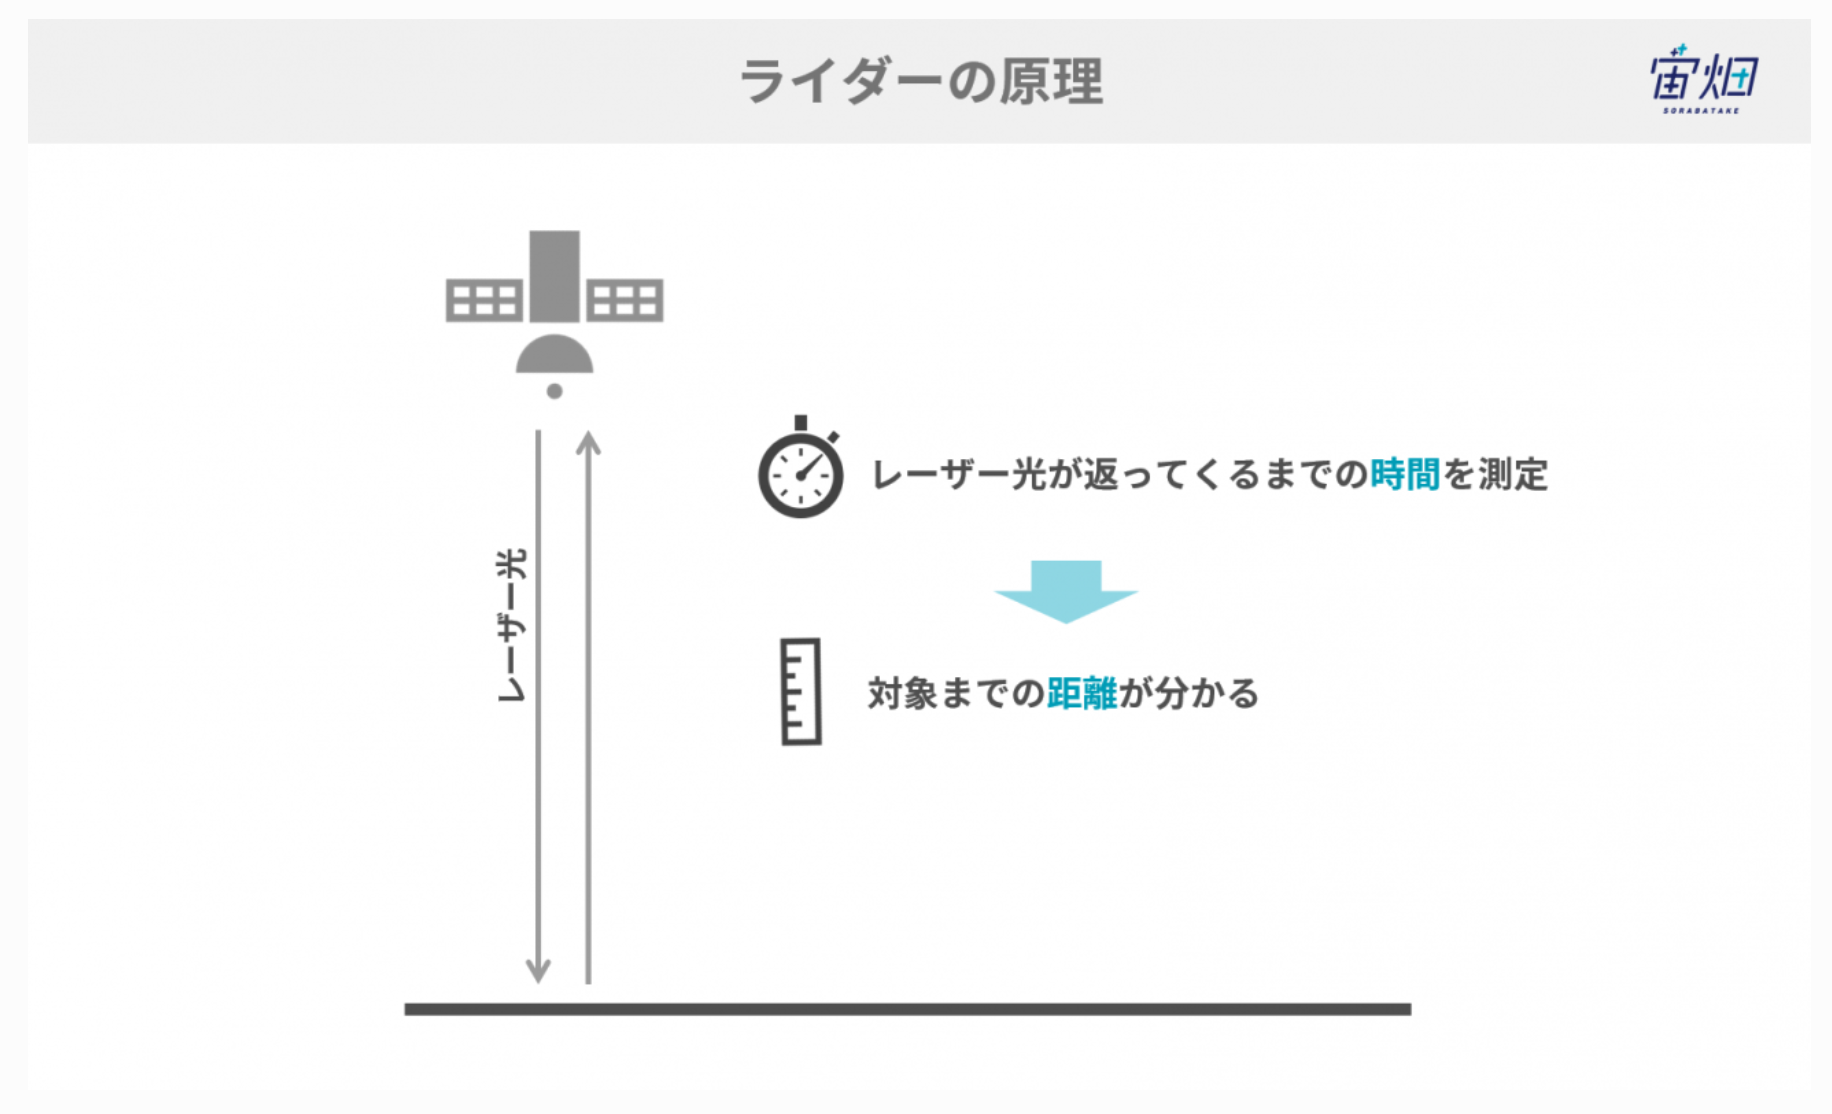

出典：https://sorabatake.jp/14216/

## GeoTransformation

ラスターデータの座標を特定の地理座標（CRS）に関連づける。

つまり、ラスターデータの原点（x0, y0）、ピクセルサイズ（X, Y）、回転方向（２方向）の６つのパラメータを変換することになる。

### Affine変換

  画像の拡大縮小(scale)、回転(rotate)、平行移動(translate)、スキュー(skew)などを行列を使って座標を変換する事。
  
  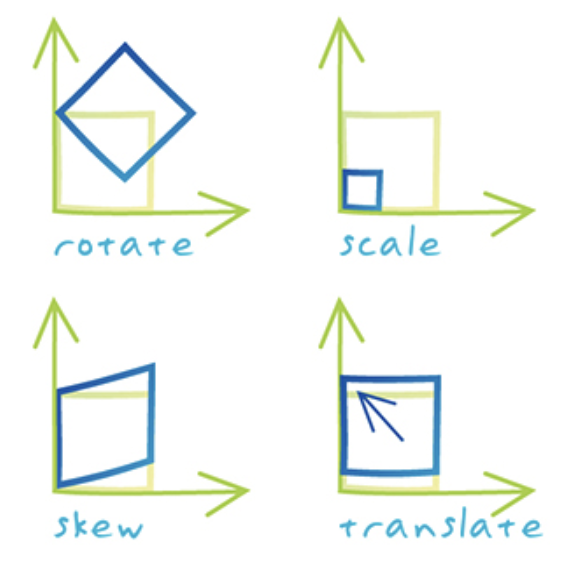
  
  出典：https://support.esri.com/ja/other-resources/gis-dictionary/term/3526be0c-e296-4c90-bb07-8a8cb121f693
  

## データ形式

ラスターデータの形式は山ほど存在する。

https://gdal.org/drivers/raster/index.html

共通しているのは

- CRS（座標参照系）の情報があること
- GeoTransformation情報（範囲や解像度）が定義されていること
- 欠損データを表す値が統一されていること


## GeoTIFF

最も一般的なラスターデータ。拡張子は `.tiff`。通常のTIFFデータに空間メタデータ（上記のGeoTransormation情報とCRS情報）が属性として埋め込まれている。


## 外部メタデータ

衛星データは多数のメタデータが存在し、衛星データ自体の外で管理されていることが一般的。例えば、衛星データの生成に使われたソフトウェア、取得した衛星、取得した日時など。

NASAはCMRというシステムで長年衛星データのメタデータを管理してきた。しかし、衛星データのユーザーとしてはCMRの全てのメタデータは必要なく、検索や品質の確保に使えれば十分。そのため [STAC](https://stacspec.org/en) というメタデータの形式が定義され、ユーザーがよく使うメタデータを使いやすくまとめている。


## GDAL（Geospatial Data Abstraction Library）

[GDAL](http://gdal.org/) はラスターデータの扱うための標準ライブラリ。

データの読み込み、書き込み、変換、検索などができる。

In [2]:
!gdalinfo --version

GDAL 3.6.0dev-e10d39568c6ab37077f4b6bc2ee3fb93e1e4d41e, released 2022/06/28


In [4]:
# GDALがサポートしているラスターデータ形式の一覧が表示される
!gdalinfo --formats

Supported Formats:
  VRT -raster,multidimensional raster- (rw+v): Virtual Raster
  DERIVED -raster- (ro): Derived datasets using VRT pixel functions
  GTiff -raster- (rw+vs): GeoTIFF
  COG -raster- (wv): Cloud optimized GeoTIFF generator
  NITF -raster- (rw+vs): National Imagery Transmission Format
  RPFTOC -raster- (rovs): Raster Product Format TOC format
  ECRGTOC -raster- (rovs): ECRG TOC format
  HFA -raster- (rw+v): Erdas Imagine Images (.img)
  SAR_CEOS -raster- (rov): CEOS SAR Image
  CEOS -raster- (rov): CEOS Image
  JAXAPALSAR -raster- (rov): JAXA PALSAR Product Reader (Level 1.1/1.5)
  GFF -raster- (rov): Ground-based SAR Applications Testbed File Format (.gff)
  ELAS -raster- (rw+v): ELAS
  ESRIC -raster- (rov): Esri Compact Cache
  AIG -raster- (rov): Arc/Info Binary Grid
  AAIGrid -raster- (rwv): Arc/Info ASCII Grid
  GRASSASCIIGrid -raster- (rov): GRASS ASCII Grid
  ISG -raster- (rov): International Service for the Geoid
  SDTS -raster- (rov): SDTS Raster
  DTED -raster- 

### データの検索と情報表示

In [10]:
HOST = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1'
IMAGE = 'LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

In [14]:
!gdalinfo /vsicurl/$HOST/$IMAGE

ERROR 11: HTTP response code: 404
gdalinfo failed - unable to open '/vsicurl/http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'.


### データ形式の変換

In [18]:
!gdal_translate -of VRT /vsicurl/$HOST/$IMAGE LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt

ERROR 11: HTTP response code: 404


In [17]:
!gdalinfo LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt | grep PROJCS

ERROR 4: LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt: No such file or directory
gdalinfo failed - unable to open 'LC08_L1TP_042034_20170616_20170629_01_T1_B4.vrt'.


## Rasterio

Rasterio は GDAL への「Pythonic」インターフェースを提供し、GDAL がサポートするほとんどの機能とフォーマットをサポートしている。

Numpyを利用してラスターデータを表現している。

### まずはラスターデータを生成する

In [1]:
import numpy as np

In [20]:
nx = 60
ny = 45
x = np.linspace(-4.0, 4.0, nx)
y = np.linspace(-3.0, 3.0, ny)
X, Y = np.meshgrid(x, y)

In [22]:
x.shape

(60,)

In [23]:
X.shape

(45, 60)

In [24]:
Z1 = np.exp(-2 * np.log(2) * ((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 1 ** 2)
Z2 = np.exp(-3 * np.log(2) * ((X + 0.5) ** 2 + (Y + 0.5) ** 2) / 2.5 ** 2)
Z = 10.0 * (Z2 - Z1)

In [28]:
Z.shape

(45, 60)

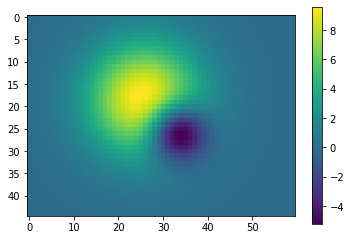

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize with matplotlib
plt.imshow(Z, origin='upper', interpolation='none')
plt.colorbar();

### Rasterioを使ってみる

- GeoTIFFファイルの作成

  下記ではgeotransformation情報とCRS情報を付与したGeoTiffファイルを保存している

In [31]:
# Create Affine geotransformation
from rasterio.transform import Affine

res = (x[-1] - x[0]) / 240.0
ulx = x[0] - res / 2
uly = y[-1] - res / 2
transform = Affine.translation(ulx, uly) * Affine.scale(res, -res)
transform

Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, -0.03333333333333333, 2.9833333333333334)

In [36]:
# Save as a Geotiff
import rasterio

with rasterio.open('example.tif', 'w',
                    driver='GTiff',
                    height=Z.shape[0],
                    width=Z.shape[1],
                    count=1,
                    dtype=Z.dtype,
                    crs='+proj=latlong', # this is a "proj4" string defining the projection
                    transform=transform,
                    ) as dst:
    dst.write(Z, 1)

- GeoTIFFファイルの読み込み

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 60, 'height': 45, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.03333333333333333, 0.0, -4.016666666666667,
       0.0, -0.03333333333333333, 2.9833333333333334), 'tiled': False, 'interleave': 'band'}


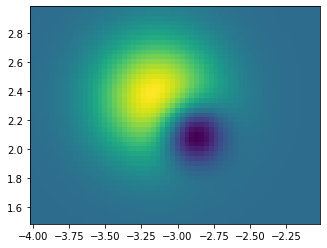

In [2]:
# Load the file into memory and plot
import rasterio.plot
with rasterio.open('example.tif') as src:
    print(src.profile)
    rasterio.plot.show(src)

- 特定の座標の値を得る

  緯度経度を指定し、numpyにおける位置を取得することで、その座標の値を確認できる

In [44]:
with rasterio.open('example.tif') as src:
    data = src.read()

In [39]:
data.shape

(1, 45, 60)

In [42]:
lon, lat = -3.33, 2.13

In [48]:
with rasterio.open('example.tif') as src:
    row, col = src.index(lon, lat)
    val = src.read(1)[row, col] # バンド1の座標データを取得しているイメージ

In [51]:
print('座標:', lon, lat, 'のデータは、行:', row, ' 列:', col, 'のデータで値は', val)

座標: -3.33 2.13 のデータは、行: 25  列: 20 のデータで値は 6.060251397244279


## Visualization?

In [5]:
!pip install ipyleaflet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 KB 17.9 MB/s eta 0:00:00


In [6]:
import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import ipywidgets
import datetime
import re

In [8]:
bbox = [43.16, -11.32, 43.54, -11.96]
west, north, east, south = bbox
bbox_ctr = [0.5*(north+south), 0.5*(west+east)] # centerを設定

NASAのGIBS（WMTSサービス=Web Map Tile Service）を使ってタイル化されたデータとして可視化できる

ipyleafletを使ってGIBSのデータセットを検索でき、ここではMODISのTRUEカラーイメージを取得する

In [22]:
# Leafletのマップを初期化
m = Map(center=bbox_ctr, zoom=6)

In [23]:
# 左下と右上を設定することでRectangleを作れる
rectangle = Rectangle(bounds=((south, west), (north, east)))

In [24]:
# basemapsを使ってGIBSのデータを取得できる
right_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, '2019-04-25')
right_layer

TileLayer(attribution='Imagery provided by services from the Global Imagery Browse Services (GIBS), operated b…

In [25]:
left_layer = TileLayer()
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)
control

SplitMapControl(left_layer=TileLayer(options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'ma…

In [26]:
m.add_control(control)
m.add_layer(rectangle)
m

Map(center=[-11.64, 43.349999999999994], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

レクチャーはここで終わっていて、可視化まで至っていない、、、

4-landsat8.ipynb以降のnotebookは古いライブラリを利用しているので参考にしない。

## USGSのデータ読み込み

usgsのGUIでダウンロードしてきたデータをrasterioで表示させているだけの例

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7621, 'height': 7771, 'count': 1, 'crs': CRS.from_epsg(32652), 'transform': Affine(30.0, 0.0, 484485.0,
       0.0, -30.0, 3787515.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


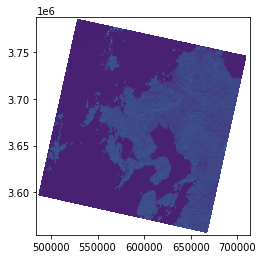

In [3]:
# Load the file into memory and plot
import rasterio.plot
with rasterio.open('usgs/LC08_L2SP_113037_20211120_20211130_02_T1_SR_B2.TIF') as src:
    print(src.profile)
    rasterio.plot.show(src)